# Titanic Competition

This is the introductory competition on Kaggle, typically used as a learning tool for newbies to data science and the Kaggle platform. A dataset of passengers on the Titanic is provided [here](https://www.kaggle.com/c/titanic/data), along with the following description:

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

>In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to **apply the tools of machine learning to predict which passengers survived the tragedy**.

So we are expected to use a binary classifier model for the outcome (`survival`) that we can train on the provided `train.csv` file, and test on the provided `test.csv` file.

Let's read in our train and test files.

In [1049]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

And we can look at the first five rows of `train`:

In [1050]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration and Cleaning

###  `Pclass`, `Sex`, and `Age`

By reorganizing and visualizing the data, we can come to two conclusions:

* Women and children were more likely to survive (which agrees with the ["women and children first"](https://en.wikipedia.org/wiki/Women_and_children_first) code of conduct)
* The higher the socio-economic status (the lower the `Pclass`), the more likely the passengers are to survive.

Below we see that about 74% of women survive, while less than 19% of men survive.

In [1051]:
train.pivot_table(index="Sex",values="Survived") * 100

,Survived
Sex,
female,74.203822
male,18.890815


As for socio-economic status, 63% of upper class passengers; 47% of middle class passengers; and 24 percent of lower class passengers survived.

In [1052]:
train.pivot_table(index="Pclass",values="Survived") * 100

,Survived
Pclass,
1,62.962963
2,47.282609
3,24.236253


Lastly, let us observe a histogram of the age of the passengers:

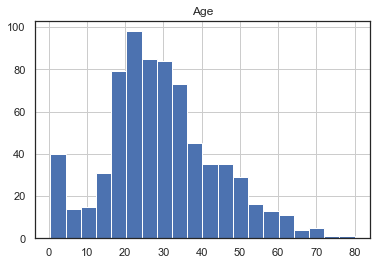

In [1053]:
import matplotlib.pyplot as plt
%matplotlib inline

train.hist(column='Age', bins=20);

Is there a threshold age below which a passenger is most likely to survive? We can create a function of a threshold `thresh` that returns the percentage of people younger than the threshold who survived.

We will plot the percentage of survivors below a threshold, along with the percentage of passengers younger than each age threshold

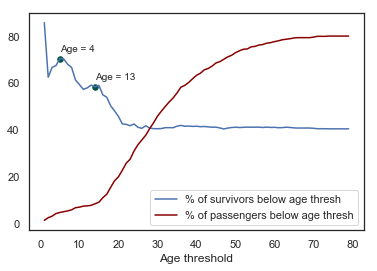

In [1054]:
import numpy as np

def pct_survivors(thresh):
    train_lt = train.loc[train['Age'] <= thresh].copy()
    return len(train_lt.loc[train_lt['Survived'] == 1])/len(train_lt) * 100

def pct_passengers(age):
    return len(train.loc[train['Age'] <= age]) / len(train) * 100

threshes = list(range(1, 80))
pcts = [pct_survivors(thresh) for thresh in threshes]
passengers = [pct_passengers(thresh) for thresh in threshes]

_, ax = plt.subplots(1, 1)
ax.plot(threshes, pcts, label='% of survivors below age thresh');
ax.plot(threshes, passengers, color='#880000', label='% of passengers below age thresh');

indices = [4, 13]
for max_index in indices:
    ax.scatter(threshes[max_index], pcts[max_index], s=30, color='#005544');
    ax.text(threshes[max_index], pcts[max_index]+3, s='Age = {}'.format(max_index));
ax.set_xlabel('Age threshold')
ax.legend();

From the graph above it seems like there are two main categories of children: young children (4 and under); and older children (between 5 and 13). The steep decline in the survival percentage after age 13 (and steep increase in the number of passengers above that age) indicates that 13 may have been the understood age of adulthood at that time. The peak at age 4 signals that while all children may have been saved first, the youngest were likely put on the lifeboats ahead of the older children.

Rather than treating the age of the passengers as a continuous variable, we can transform it into a categorical one by age group. Let's view a bar plot of the survival frequencies, creating a few more age groups among the adults. We will create a `Missing` category for those rows without ages as well.

In [1055]:
def survival_freqs(cut_points, labels):
    ages = train[['Age', 'Survived']].copy()
    ages['Age'].fillna(-0.5, inplace=True)
    ages['Age'] = pd.cut(ages['Age'], cut_points, labels=labels)
    return ages.pivot_table(index='Age', values='Survived')

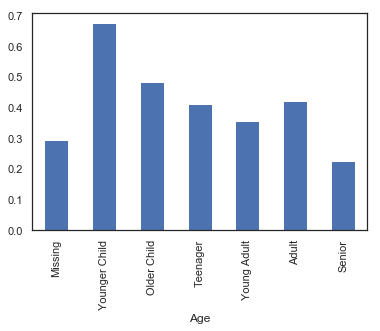

In [1056]:
cut_points = [-1, 0, 4, 13, 18, 30, 60, 100]
label_names = ['Missing', 'Younger Child', 'Older Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
survival_freqs(cut_points, label_names).plot.bar(legend=False);

From this we have learned that seniors have the lowest survival rate, indicating that we should indeed distinguish them from younger adults. But the `Teenager`, `Young Adult`, and `Adult` categories do not provide use with much additional information. Let's try the same thing with five categories (not including `Missing`):

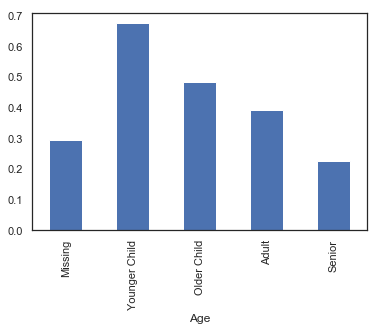

In [1057]:
cut_points = [-1, 0, 4, 13, 60, 100]
label_names = ['Missing', 'Younger Child', 'Older Child', 'Adult', 'Senior']
survival_freqs(cut_points, label_names).plot.bar(legend=False);

This gives us a nice, monotonic relationship between the age group and the survival probability (though the `Missing` category makes things a bit messier).

### Dummy Columns

We can now clean our data by converting the `Age`, `Sex`, and `Pclass` columns mentioned in the previous section into categories - along with the `Embarked` column. `Embarked` represents one of three possible ports of embarkation, and it breaks down in the following way:

In [1058]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [1059]:
# number of null entries
len(train.loc[pd.isnull(train['Embarked'])])

2

Since there are only two null entries for `Embarked`, we'll set them equal to the majority class (`S`)

In [1060]:
train.loc[pd.isnull(train['Embarked']), 'Embarked'] = 'S'

For all the aforementioned columns we will derive **dummy columns**, which split each possible value for a category into its own column with a value of 0 or 1. For example, rather than have a single column for `Sex` with a value of `male` or `female`, we will have `Sex_male` and `Sex_female` columns. Each dummy column takes on a value of 1 if the category applies to the passenger, and 0 otherwise. This is a common way of making qualitative fields (or ordinal fields where the distances between categories is unknown) friendly to machine learning models.

The full list of dummy columns contains one column more than we actually need; because each row only contains a single value of 1, we can infer the value of any column by inspecting the values of the others. Thus, we will leave off one column each time we create the dummy columns from the categories.

We will create dummy columns for `Pclass`, `Sex`, `Embarked`, and a new `AgeGroup` column that simply bins the ages into the age groups discussed above.

In [1061]:
def age_map(age):
    if 0 <= age < 4:
        return 'younger_child'
    if 4 <= age < 13:
        return 'older_child'
    if 13 <= age < 60:
        return 'adult'
    if age >= 60:
        return 'senior'
    return 'missing'  # otherwise missing

train['AgeGroup'] = train['Age'].map(age_map)
test['AgeGroup'] = test['Age'].map(age_map);

Here is a function to help us create our dummy columns.

In [1062]:
train_predict_cols = list()
test_predict_cols = list()

def create_dummies(column_names):
    dummy_cols = list()
    output_dfs = list()
    dfs = [train, test]
    for df in dfs:
        current_dummy_cols = list()
        for col in column_names:
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            current_dummy_cols.extend(list(dummies.columns))
        
        # get rid of last dummy column
        last_col = current_dummy_cols[-1]
        current_dummy_cols.remove(last_col)
        output_dfs.append(df.drop(columns=[last_col]))
        dummy_cols.append(current_dummy_cols)
    
    # this function has the side-effect of tacking on new column names to train_predict_cols and test_predict_cols
    train_predict_cols.extend(dummy_cols[0])
    test_predict_cols.extend(dummy_cols[1])
    
    return output_dfs[0], output_dfs[1]

In [1063]:
prefixes = ['AgeGroup', 'Sex', 'Pclass', 'Embarked']
train, test = create_dummies(prefixes)

### Other Columns

We still have several columns left to look at: `PassengerId`, `Name`, `SibSp`, `Parch`, `Ticket`, `Fare`, and `Cabin`. `PassengerId` is just a random ID assigned to the passenger, so we won't use this at all. Let us look at the three quantitative columns: `SibSp`, `Parch`, and `Fare`

In [1064]:
other_cols = ['SibSp', 'Parch', 'Fare']
train[other_cols].describe()

,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000
mean,0.523008,0.381594,32.204208
std,1.102743,0.806057,49.693429
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.910400
50%,0.000000,0.000000,14.454200
75%,1.000000,0.000000,31.000000
max,8.000000,6.000000,512.329200


The first three columns are numerical, and their ranges vary greatly (e.g. `Fare` ranges from 0 to about 512, while `SibSp` ranges from 0 to 8. We would like to rescale the numerical columns between 0 and 1. We can either use a min-max scaling between 0 and 1, or we can bin the columns into groups and create dummy columns.

#### `Fare`
Let's look at `Fare` and make it categorical by binning it into groups.

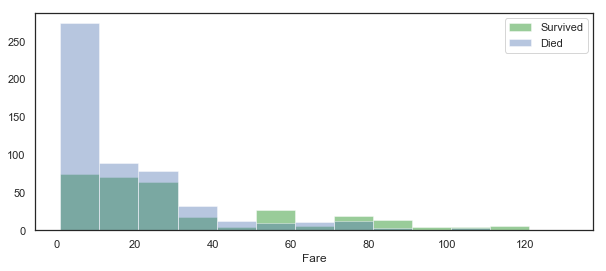

In [1065]:
import seaborn as sns

def dual_dist_plot(col, ax=None, bins=10):
    if ax is None:
        _, ax = plt.subplots(1, 1)
        
    sns.distplot(train.loc[train['Survived'] == 1, col], bins=bins, kde=False, label='Survived', color='green', ax=ax)
    sns.distplot(train.loc[train['Survived'] == 0, col], bins=bins, kde=False, label='Died', ax=ax)
    ax.legend();
    
bins = list(range(1, 140, 10))
_, ax = plt.subplots(1, 1, figsize=(10, 4))
dual_dist_plot('Fare', ax=ax, bins=bins)

We will bin the fares into 4 groups:

* \\$0-\\$10: spike in the death toll up to $10
* \\$11 - \\$50: survival and death tolls both decrease with fare up to \\$50
* \\$50-\\$90: boost in survivors
* \\$90+: outliers

Let us create a `Fare_categories` column from which we will derive dummy columns.

In [1066]:
cut_points = [0, 10, 50, 90, 1000]
label_names = ['0-10', '10-50', '50-90', '90+']

train['Fare_categories'] = pd.cut(train['Fare'], cut_points, labels=label_names)
test['Fare_categories'] = pd.cut(test['Fare'], cut_points, labels=label_names)

train, test = create_dummies(['Fare_categories'])

#### `Name`

The `Name` column may be specific to each individual passenger, but there are a relatively small selection of **titles** each passenger can have. We can extract the title by selecting the first word after the comma, as names are specified in "last name, first name" format.

We will look at both the train and test dataframes in case members with a new title are present in one dataset and not the other.

In [1067]:
def title_map(name):
    return name.split(',')[1].split()[0].strip()
train_titles = train['Name'].map(title_map)
test_titles = test['Name'].map(title_map)
titles = np.unique(train_titles.tolist() + test_titles.tolist())
print(titles)

['Capt.' 'Col.' 'Don.' 'Dona.' 'Dr.' 'Jonkheer.' 'Lady.' 'Major.'
 'Master.' 'Miss.' 'Mlle.' 'Mme.' 'Mr.' 'Mrs.' 'Ms.' 'Rev.' 'Sir.' 'the']


The only suspicious title is 'the', which is likely part of a longer title that has been truncated. Let us expand any rows with this title.

In [1068]:
the_rows = train_titles.loc[train_titles == 'the']
# the_rows
train.iloc[the_rows.index]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Fare_categories,Fare_categories_0-10,Fare_categories_10-50,Fare_categories_50-90
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,...,0,1,0,0,0,0,50-90,0,0,1


So the title is really *Countess.* This does not occur in the test dataset.

In [1069]:
titles = [title if title != 'the' else 'Countess.' for title in titles]
titles

['Capt.',
 'Col.',
 'Don.',
 'Dona.',
 'Dr.',
 'Jonkheer.',
 'Lady.',
 'Major.',
 'Master.',
 'Miss.',
 'Mlle.',
 'Mme.',
 'Mr.',
 'Mrs.',
 'Ms.',
 'Rev.',
 'Sir.',
 'Countess.']

Some of these titles are specific to certain nations or regions. For example, `Jonkheer` is a member of the nobility in the Netherlands, `Mlle` is the French word "Mademoiselle" and refers to an unmarried woman, and `Don`/`Dona` are words for nobility in Portugal, Spain, and several other countries. We should therefore break down these more obscure titles into their equivalent classes in English. We will use the mapping below

In [1070]:
title_dict = {
    "Mr." :         "Mr",
    "Mme.":         "Mrs",
    "Ms.":          "Mrs",
    "Mrs." :        "Mrs",
    "Master." :     "Master",
    "Mlle.":        "Miss",
    "Miss." :       "Miss",
    "Capt.":        "Military",
    "Col.":         "Military",
    "Major.":       "Military",
    "Dr.":          "Dr",
    "Rev.":         "Rev",
    "Jonkheer.":    "Nobility",
    "Don.":         "Nobility",
    "Sir." :        "Nobility",
    "Countess.":    "Nobility",
    "Dona.":        "Nobility",
    "Lady." :       "Nobility"
}

In [1071]:
train['Title'] = train_titles.map(title_dict)
test['Title'] = test_titles.map(title_dict)

In [1072]:
train, test = create_dummies(['Title'])

#### `Cabin`

As for the cabin, we really only care about the cabin section, which is indicated by the first letter. We will extract this from each cabin and insert it into a column `Cabin_type`

In [1073]:
train['Cabin_type'] = train['Cabin'].map(lambda x: x if pd.isnull(x) else x[0])
train['Cabin_type'].fillna('Unknown', inplace=True)

test['Cabin_type'] = test['Cabin'].map(lambda x: x if pd.isnull(x) else x[0])
test['Cabin_type'].fillna('Unknown', inplace=True)

train, test = create_dummies(['Cabin_type'])

#### `SibSp`

Let's look at `SibSp` - the number of siblings (or spouses) the passenger has

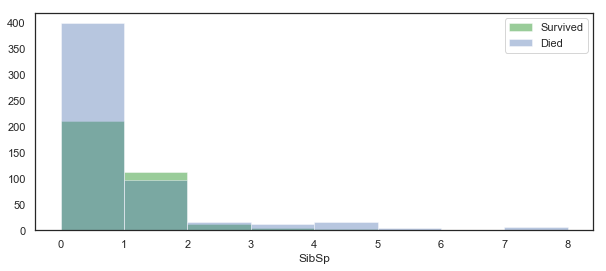

In [1074]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
dual_dist_plot('SibSp', ax=ax, bins=list(range(0, 9)))

So we are best off splitting the data into unaccompanied people; people with 1-2 siblings/spouses, and people with 2 or more siblings.

This captures variations in the data. Unaccompanied passengers were very likely to die; people with 1-2 siblings (or a spouse + 0-1 siblings) had a 50-50 chance of living or dying; and people with 3+ siblings (or a spouse  were more likely to die.

In [1075]:
def sib_map(sib):
    if sib == 0:
        return '0'
    if sib in (1, 2):
        return '1-2'
    if sib >= 3:
        return '3+'
    return 'missing'  # otherwise missing

train['SibGroup'] = train['SibSp'].map(sib_map)
test['SibGroup'] = test['SibSp'].map(sib_map)

train, test = create_dummies(['SibGroup'])

### `Parch`

Now let's visualize the `Parch` column - or the number of parents or children on the Titanic.

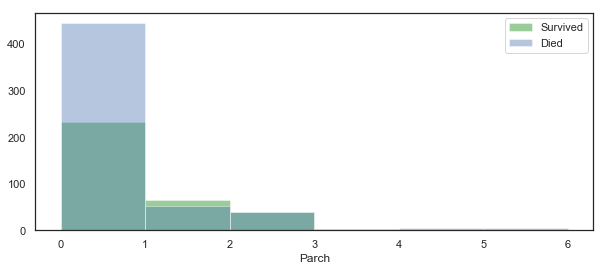

In [1076]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
dual_dist_plot('Parch', ax=ax, bins=list(range(0, 7)))

We can split this into two groups.

* 0 parents/children (more likely to die)
* 1+ parents/children (more even chance)

In [1077]:
def parch_map(parch):
    if parch == 0:
        return '0'
    if parch >= 1:
        return '1+'
    return 'missing'  # otherwise missing

train['ParchGroup'] = train['Parch'].map(parch_map)
test['ParchGroup'] = test['Parch'].map(parch_map)

train, test = create_dummies(['ParchGroup'])

#### Redundant columns

Lastly, let's look at the correlation coefficients between the predictor columns, to see if we have columns that may provide information that can be inferred from others.

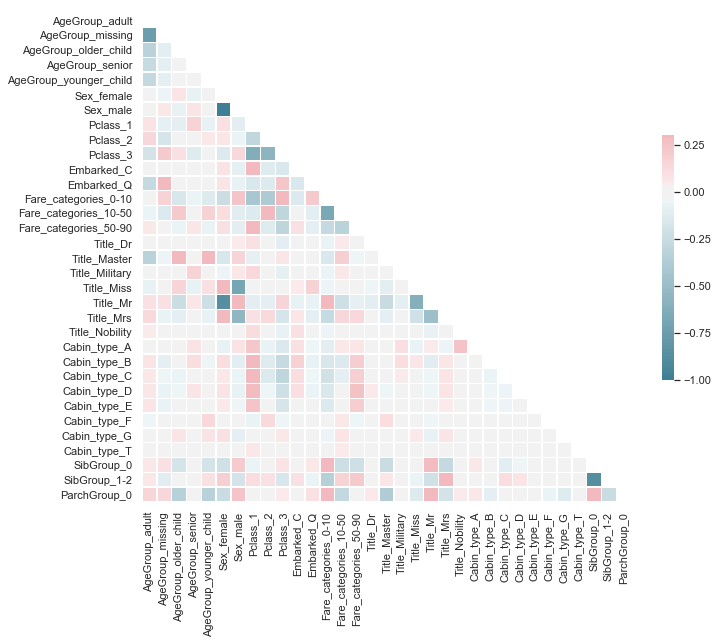

In [1078]:
corr = train[train_predict_cols].corr()
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

_, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

One of the strongest patches of highly-correlated cells occurs between the masculine and feminine titles and the sex columns. We can safely eliminate the sex columns.

In [1079]:
[train_predict_cols.remove('Sex_{}'.format(x)) for x in ('male', 'female')];
[test_predict_cols.remove('Sex_{}'.format(x)) for x in ('male', 'female')];

We also observe a weak positive correlation between certain cabin types, passenger classes, and fares. These three are clearly all conceptually correlated.

As for `Cabin`, it has 204 non-null entires out of 891 total rows, so it is not all that useful.

It is now time to set up our predictors and target.

### Predictor and Target Split

In the previous section we developed the list of predictor columns. The target column, of course, is `Survived`. So let's create separate structures for the target and predictors for the training set (the test set does not have a `Survived` column).

Also - recall that we have `train_predict_cols` and `test_predict_cols` structures. We only want to use the columns that are present in both. Thus, we will create a `predict_cols` list that only includes entries from `train_predict_cols` that are also present in `test_predict_cols`

In [1080]:
target_col = 'Survived'
predict_cols = [x for x in train_predict_cols if x in test_predict_cols]
X_train, y_train, X_test = train[predict_cols], train[target_col], test[predict_cols]

To construct a decent model, we will further split our training data into subsets and try to "predict" values from one subset using a model fit from the others. This allows us to determine how accurate our model is at predicting the survival outcome from new data. We will compute a metric called the accuracy score, which computes the fraction of predictions that were correct.

## Analysis

Now that we have chosen our predictors and divided our training data accordingly, we can develop the model! Though there are many choices, we will use a logistic regression model to keep things simple.

### Logistic Regression

We will set up a logistic regression model using the `LogisticRegression` class in the `scikit-learn` `linear_model` module.

We will use `RFECV` to choose the best features for training the model.

In [1081]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
selector = RFECV(lr, cv=10)
selector.fit(X_train, y_train)
log_best_features = X_train.columns[selector.support_]
print(list(log_best_features))

['Pclass_1', 'Title_Master', 'Title_Miss', 'Title_Mrs', 'SibGroup_0', 'SibGroup_1-2']


The titles encompass the wealth of the passenger (`Pclass_1` is a wealth indicator, essentially); age (`Master` is a designation for male children); marital status (`Miss` versus `Mrs`); gender; and whether or not the passenger is accompanied. So it makes sense that these were chosen as features.

#### Cross-Validation

We will determine the training error using 10-fold cross-validation via `cross_val_score`. So the data is divided into 10 sets, one of which is treated as the testing data for prediction. The scores are calculated for each configuration, yielding a list of ten values. The average is taken as the final CV score.

In [1082]:
lr = LogisticRegression(solver='newton-cg', max_iter=1000)
scores = cross_val_score(lr, X_train[log_best_features], y_train, cv=10, scoring='accuracy')
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.84444444 0.83333333 0.78651685 0.87640449 0.83146067 0.80898876
 0.78651685 0.76404494 0.83146067 0.84090909]
0.8204080127113835


So the model is accurate an average of 82% of the time.

When submitted to Kaggle, this model yields a score of 0.78468 on the testing data.

## Submission

The submission should be a CSV file with two columns: `PassengerId` and `Survived`. We will construct the prediction DataFrame and then export to a CSV file.

In [1103]:
lr.fit(X_train[log_best_features], y_train)
log_predictions = lr.predict(X_test[log_best_features])
log_submission_df = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': log_predictions})
log_submission_df.to_csv('submission_logistic.csv', index=False)

And that's it!